In [67]:
# Standard library
from scipy.optimize import curve_fit

# Third-party libraries
import gvar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from pysr import PySRRegressor

# Local modules
from nuclr.fitting import (calculate_PCA, envelope, find_local_minima_maxima, get_nucl_range, 
                     get_range_dat, mask_uncertainities, PCA_fit, polynomial, preds_targets_zn, rms_val)
from nuclr.train import Trainer
from nuclr.data import semi_empirical_mass_formula

import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
sns.set()
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [3]:
model_path = "spiral"
trainer = Trainer.from_path(model_path)

No sn, sp or binding data, skipping leave one out


In [4]:
model = trainer.models[0].cpu()
task_names = list(trainer.data.output_map.keys())

magic_numbers = [2, 8, 20, 28, 50, 82, 126]
data = trainer.data

In [5]:
proton_embs, neutron_embs, task_embs = model.emb
proton_embs = proton_embs.weight.detach().cpu().numpy()
neutron_embs = neutron_embs.weight.detach().cpu().numpy()
task_embs = task_embs.weight.detach().cpu().numpy()

In [6]:
znt = data.X[data.X[:, 2] == task_names.index("binding_semf")]
znt_np = znt.cpu().detach().numpy()
embs = model.embed_input(znt, model.emb)

In [7]:
znt

tensor([[  9,   9,   0],
        [  9,  10,   0],
        [  9,  11,   0],
        ...,
        [117, 176,   0],
        [117, 177,   0],
        [118, 176,   0]])

In [85]:
# A modified version to return everything that we need.
def plot_N_vs_pc_mod(task_name, Z_number, pca_comp, model, task_names, data):
    """
    Plot a specific task against a principal component, while keeping the number of protons (Z) fixed and varying the number of neutrons (N).

    Parameters:
    - task_name (str): The name of the task to plot.
    - Z_number (int): The atomic number (number of protons) to keep fixed.
    - pca_comp_x_axis (int): The index of the PCA component to use for the x-axis.
    - model
    - task_names (list): List of all task names.
    """
    # Find index of the task in the list of all tasks
    task_idx = task_names.index(task_name)
    max_neutrons = 140

    inputs = torch.full((max_neutrons - 9, 3), Z_number) # 9 is the minimum number of neutrons
    inputs[:, 1] = torch.arange(9, max_neutrons) # change the number of neutrons
    inputs[:, 2] = task_idx # change the task index

    znt = data.X[data.X[:, 2] == task_idx]
    znt_for_mask = znt[znt[:,0] == Z_number]
    mask_data = torch.isin(inputs[:, 1], znt_for_mask[:, 1])
    embs = model.embed_input(inputs, model.emb)

    pca = PCA(n_components=1)
    embs_pca = pca.fit_transform(embs.detach().cpu().numpy())
    print("PCA:", pca.explained_variance_ratio_, "\n")

    emb_pca_comp = embs_pca[:, pca_comp]
    
    # Plotting
    sns.scatterplot(x=inputs[:,1], y=emb_pca_comp, marker='o')
    sns.scatterplot(x=inputs[mask_data][:,1],y=emb_pca_comp[mask_data], marker='o', c='orange', s=20)
    plt.ylabel(f"PC{pca_comp}")
    plt.xlabel(f"N")
    plt.title(f"PCA vs N for Z={Z_number}")
    plt.show()

    return inputs[:,1].detach().cpu().numpy(), emb_pca_comp, embs_pca, pca, inputs, mask_data

PCA: [0.43487227] 



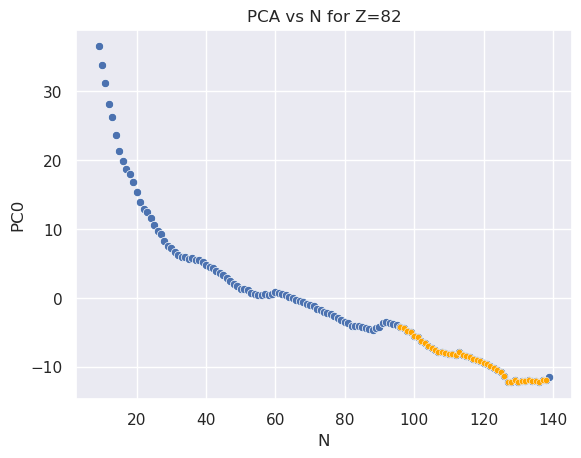

In [86]:
X_fit_N, emb_pca_comp, embs_pca, pca, inputs, mask_data = plot_N_vs_pc_mod("binding_semf", Z_number=82, pca_comp=0, model=model, task_names=task_names, data=data);

#### Reconstruction

---

In [10]:
def fourier_series(t, freq, coeffs):
    #freq = 0.01
    a0 = coeffs[0]
    result = a0
    num_harmonics = (len(coeffs) - 1) // 2
    for n in range(1, num_harmonics + 1):
        an = coeffs[2*n - 1]
        bn = coeffs[2*n]
        result += an * np.cos(n * freq * t) + bn * np.sin(n * freq * t)
    return result

In [11]:
def func_N_to_PC(csv_path, pc_idx, Xfit_N, fourier_series):
    # function in construction
    freqs = [0.01, 0,0,0, 0.04] # freqs for 5 pcas
    params_df = pd.read_csv(csv_path, index_col=0)
    params_pc = params_df.iloc[:,pc_idx].to_numpy()
    fit_y = fourier_series(Xfit_N, freq=freqs[pc_idx], coeffs=params_pc)
    return fit_y

In [12]:
def func_PC_to_binding(csv_path, pc_idx, pc_comp, fourier_series):
    # function in construction
    freqs = [0.1] # freqs for 5 pcas
    params_df = pd.read_csv(csv_path, index_col=0)
    params_pc = params_df.iloc[:,pc_idx].to_numpy()
    fit_y = fourier_series(pc_comp, freq=freqs[pc_idx], coeffs=params_pc)
    return fit_y

In [144]:
reconstructed_pc_0 = func_N_to_PC('pcs_vs_N_fits_fourier_5.csv', 0, X_fit_N, fourier_series)

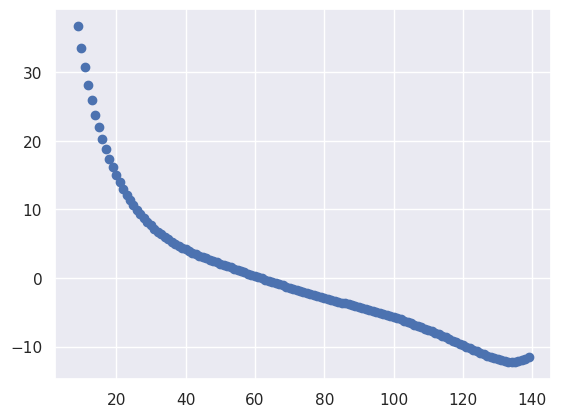

In [145]:
plt.scatter(x=X_fit_N, y=reconstructed_pc_0)

In [146]:
# Reconstructed binding from reconstructed PC
rec_BE_rec_PC = func_PC_to_binding('binding_vs_pc_5.csv', 0, reconstructed_pc_0, fourier_series)

In [147]:
X, targets_semf, targets, preds_nuclr_semf = preds_targets_zn(model, data, 'binding_semf', train=True, val=True)

In [148]:
embs_pca_with_fit_0 = embs_pca
embs_pca_with_fit_0[:, 0] = reconstructed_pc_0.reshape(-1)

recons_embs = pca.inverse_transform(embs_pca_with_fit_0)

# Convert NumPy array to PyTorch tensor
recons_embs_torch = torch.from_numpy(recons_embs).float().to(embs.device)

In [149]:
semf = semi_empirical_mass_formula(inputs[:, 0], inputs[:, 1]).cpu().numpy()

preds_before = torch.sigmoid(model.readout(model.nonlinear(recons_embs_torch)))
preds_before = preds_before.cpu().detach().numpy()
preds_before = data.regression_transformer.inverse_transform(preds_before)[:, 0]

# Predictions from NuCLR after evaluating a fit of a PC and reconstructing the embeddings with it + SEMF
preds_reconstructed_semf = preds_before + semf

In [150]:
preds = model(inputs)
preds = preds.cpu().detach().numpy()
preds = data.regression_transformer.inverse_transform(preds)[:, 0]

# Raw predictions from NuCLR + SEMF
preds_nuclr_semf = preds + semf 

In [151]:
rec_BE_rec_PC_semf = rec_BE_rec_PC + semf

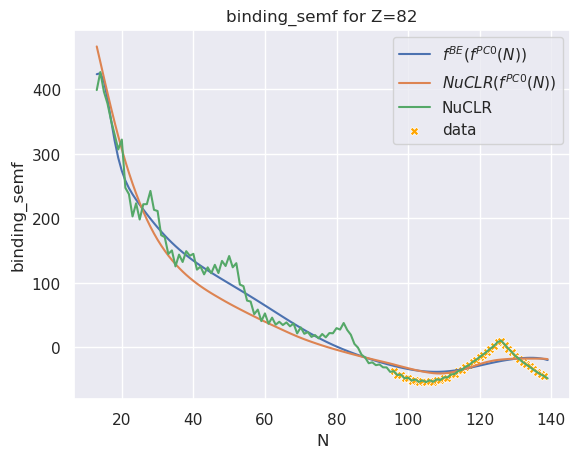

In [152]:
min_nucl = 12
min_nucl_mask = X_fit_N > 12
sns.lineplot(x=X_fit_N[min_nucl_mask], y=rec_BE_rec_PC[min_nucl_mask], label=r'$f^{BE}(f^{PC0}(N))$')
sns.lineplot(x=X_fit_N[min_nucl_mask], y=preds_before[min_nucl_mask],  label=r'$NuCLR(f^{PC0}(N))$')
sns.lineplot(x=X_fit_N[min_nucl_mask], y=preds[min_nucl_mask], label='NuCLR')
sns.scatterplot(x=X[X[:,0] == 82][:,1], y=targets[X[:,0] == 82], c='orange', marker='X',label=r'data')

plt.xlabel('N')
plt.ylabel('binding_semf')
plt.title('binding_semf for Z=82')
plt.legend()
plt.savefig("plots/functions_NuCLR_data_fourier_5.png", dpi=300)

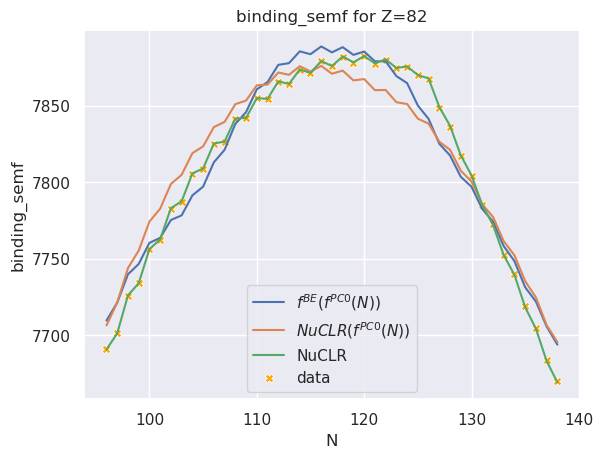

In [127]:
sns.lineplot(x=X_fit_N[mask_data], y=rec_BE_rec_PC_semf[mask_data], label=r'$f^{BE}(f^{PC0}(N))$')
sns.lineplot(x=X_fit_N[mask_data], y=preds_reconstructed_semf[mask_data], label=r'$NuCLR(f^{PC0}(N))$')
sns.lineplot(x=X_fit_N[mask_data], y=preds_nuclr_semf[mask_data], label='NuCLR')
sns.scatterplot(x=X[X[:,0] == 82][:,1], y=targets_semf[X[:,0] == 82], c='orange', marker='X', label='data')

plt.xlabel('N')
plt.ylabel('binding_semf')
plt.title('binding_semf for Z=82')
plt.legend()

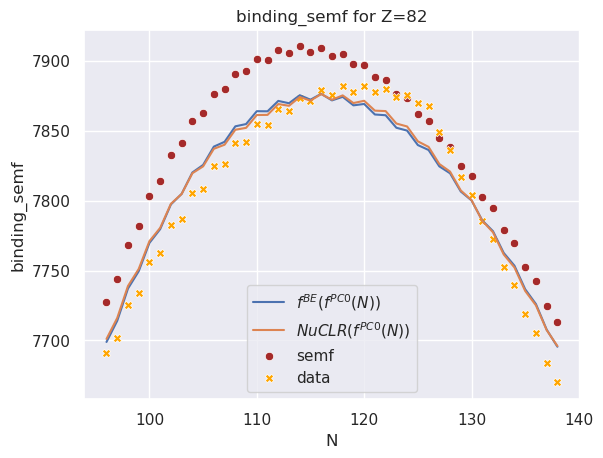

In [153]:
sns.lineplot(x=X_fit_N[mask_data], y=rec_BE_rec_PC_semf[mask_data], label=r'$f^{BE}(f^{PC0}(N))$')
sns.lineplot(x=X_fit_N[mask_data], y=preds_reconstructed_semf[mask_data], label=r'$NuCLR(f^{PC0}(N))$')
sns.scatterplot(x=X_fit_N[mask_data], y=semf[mask_data], marker='o', label='semf', c = 'brown')
sns.scatterplot(x=X[X[:,0] == 82][:,1], y=targets_semf[X[:,0] == 82], c='orange', marker='X', label='data')

plt.xlabel('N')
plt.ylabel('binding_semf')
plt.title('binding_semf for Z=82')
plt.legend()
plt.savefig('plots/semf_functions_data_fourier_5.png', dpi=300)